In [1]:
!pip install pytorchcv

     |████████████████████████████████| 435 kB 3.4 MB/s 


In [2]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
import seaborn as sn
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch
from torch.autograd import Variable
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Load dataset

In [3]:
train_data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
training_set = datasets.ImageFolder(root='../input/covid19xray/covid-19-dataset/train',
                                           transform=train_data_transform)

/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:704: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


In [4]:
val_data_transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_set = datasets.ImageFolder(root='../input/covid19xray/covid-19-dataset/test',
                               transform=val_data_transform)

In [5]:
dataloaders = {'train':  torch.utils.data.DataLoader(training_set,
                                             batch_size=64, shuffle=True),
               'val':torch.utils.data.DataLoader(test_set,
                                             batch_size=64, shuffle=True)}

dataset_sizes = {'train': len(training_set) ,'val':len(test_set)}
class_names = training_set.classes  
print(class_names)

['COVID-19', 'NORMAL', 'Viral Pneumonia']


## Data exploration

Text(0.5, 1.0, 'Distribution of training set target variable ')

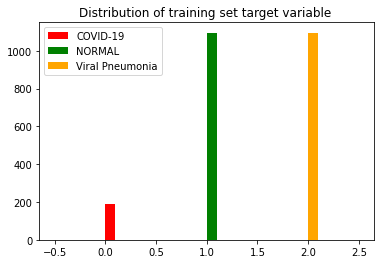

In [6]:
label_0=[0 for i in range(len(training_set)) if training_set[i][1] ==0 ]
label_1=[1 for i in range(len(training_set)) if training_set[i][1] ==1 ]
label_2=[2 for i in range(len(training_set)) if training_set[i][1] ==2]
plt.hist(label_0,histtype='bar',color='red',label=class_names[0])
plt.hist(label_1,histtype='bar',color='green',label=class_names[1])
plt.hist(label_2,histtype='bar',color='orange',label=class_names[2])
plt.legend(prop={'size': 10})
plt.title("Distribution of training set target variable ")

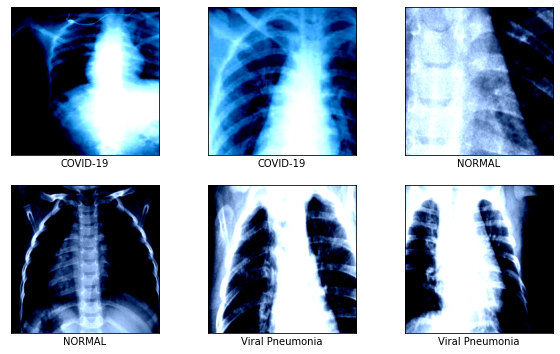

In [7]:
image_1,label_1=training_set[0]
image_2,label_2=training_set[1]
image_3,label_3=training_set[289]
image_4,label_4=training_set[289+1]
image_5,label_5=training_set[289+1095]
image_6,label_6=training_set[289+1095+1]
images=[image_1,image_2,image_3,image_4,image_5,image_6]
labels=[label_1,label_2,label_3,label_4,label_5,label_6]
plt.figure(figsize=(10,6))
for i in range(6):
    image=images[i]
    image=np.transpose(image,(1,2,0))
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i]])


## Use build model based on transfert learning

## Utils functions

In [8]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses={'train':[],'val':[]}
    accuracy={'train':[],'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for iter, batch in enumerate(dataloaders[phase]):
                inputs,labels=batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase]=losses[phase]+[epoch_loss]
            accuracy[phase]=accuracy[phase]+[epoch_acc]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return {"model":model,'losses':losses,'accuracy':accuracy}


In [9]:

def tensorbord(epoch,results):
    epochs=np.arange(1,epoch+1)
    losses=results["losses"]
    accuracy=results["accuracy"]
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(epochs,losses["train"],label="train",color="orange")
    plt.plot(epochs,losses["val"],label="val",color="green")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Train/Val losses")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs,accuracy["train"],label="train",color="orange")
    plt.plot(epochs,accuracy["val"],label="val",color="green")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Train/Val accuracy")
    plt.legend()
    return


In [10]:
def visualize_prediction(model, num_images=9):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12,11))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            scores = F.softmax(outputs,dim=1)
            cfs, _ = torch.max(scores, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(3,3,images_so_far)
                image=inputs.cpu().data[j]
                image=np.transpose(image,(1,2,0))
                plt.imshow(image)
                plt.xticks([])
                plt.yticks([])
                plt.xlabel("actual: "+str(class_names[labels[j]]),color="green")
                plt.title('predicted: {} {}%'.format(class_names[preds[j]],round(float(100*cfs[j]),1)),
                          color="orange")
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
def evaluate(model):
    model.eval()
    data=torch.utils.data.DataLoader(test_set,batch_size=len(test_set), shuffle=True)
    with torch.no_grad():
            for iter,batch in enumerate(data):
                images,labels=batch
                images=images.to(device)
                labels=labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                print(classification_report(labels.cpu(),  preds.cpu(), target_names=class_names))
                cm=confusion_matrix(labels.cpu(),preds.cpu())
                df_cm = pd.DataFrame(cm, index = class_names,columns = class_names)
                plt.figure(figsize = (10,5))
                sn.heatmap(df_cm, annot=True)
               
    return 
        

## Fisrt model : Resnet18 

In [12]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)
resnet=resnet.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001, weight_decay=0.0005)
#optimizer_ft = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
results = train_model(resnet, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=100)

Epoch 1/100
----------
train Loss: 0.5075 Acc: 0.8240
val Loss: 1.5897 Acc: 0.4792

Epoch 2/100
----------
train Loss: 0.3490 Acc: 0.8728
val Loss: 0.5887 Acc: 0.7906

Epoch 3/100
----------
train Loss: 0.3408 Acc: 0.8745
val Loss: 0.1432 Acc: 0.9528

Epoch 4/100
----------
train Loss: 0.3006 Acc: 0.8880
val Loss: 0.1589 Acc: 0.9396

Epoch 5/100
----------
train Loss: 0.2614 Acc: 0.9086
val Loss: 1.8428 Acc: 0.5019

Epoch 6/100
----------
train Loss: 0.3034 Acc: 0.8880
val Loss: 0.2652 Acc: 0.8925

Epoch 7/100
----------
train Loss: 0.2915 Acc: 0.8960
val Loss: 0.9331 Acc: 0.6887

Epoch 8/100
----------
train Loss: 0.3025 Acc: 0.8918
val Loss: 0.2792 Acc: 0.9000

Epoch 9/100
----------
train Loss: 0.2671 Acc: 0.9002
val Loss: 0.1626 Acc: 0.9358

Epoch 10/100
----------
train Loss: 0.2807 Acc: 0.8947
val Loss: 0.1389 Acc: 0.9509

Epoch 11/100
----------
train Loss: 0.2208 Acc: 0.9280
val Loss: 0.1268 Acc: 0.9604

Epoch 12/100
----------
train Loss: 0.1957 Acc: 0.9339
val Loss: 0.0988 Ac

In [14]:
resnet=results["model"]
torch.save(resnet, "resnet-covid-19-model.pth")
torch.save(resnet.state_dict(),"resnet-covid-19-weigths.pth" )

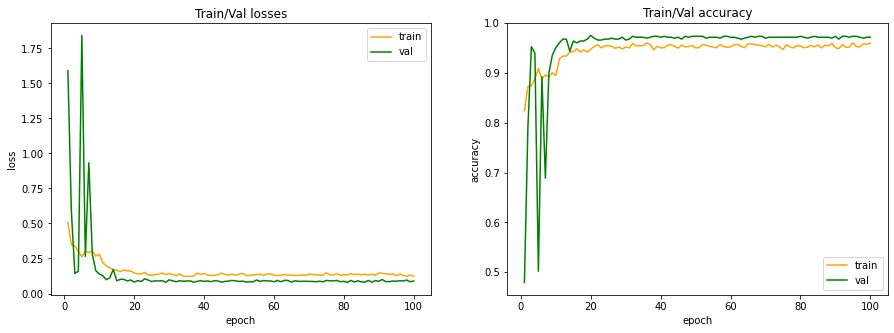

In [15]:
tensorbord(100,results)

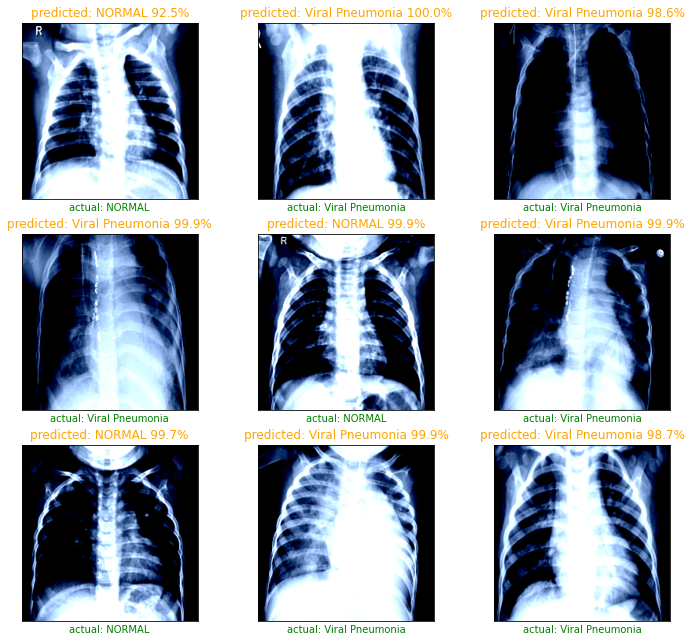

In [16]:
visualize_prediction(model=resnet, num_images=9)

                 precision    recall  f1-score   support

       COVID-19       0.97      1.00      0.98        30
         NORMAL       0.97      0.98      0.98       250
Viral Pneumonia       0.98      0.96      0.97       250

       accuracy                           0.98       530
      macro avg       0.97      0.98      0.98       530
   weighted avg       0.98      0.98      0.98       530



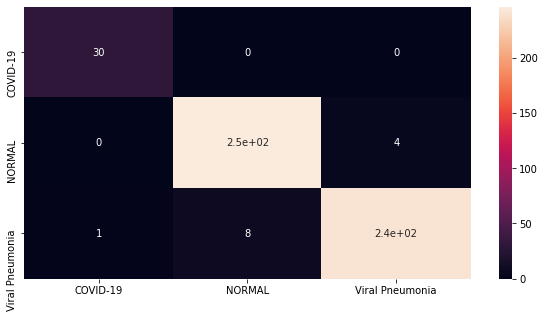

In [17]:
evaluate(resnet)

## 2nd model : Darknet53

In [18]:
darknet53 = ptcv_get_model("darknet53", pretrained=True)
darknet53.output=nn.Linear(1024, 3)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
darknet53=darknet53.to(device)
optimizer = torch.optim.Adam(darknet53.parameters(), lr=0.001, weight_decay=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

results_darknet53 = train_model(darknet53, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=100)

Epoch 1/100
----------
train Loss: 0.5775 Acc: 0.7882
val Loss: 9.5029 Acc: 0.5472

Epoch 2/100
----------
train Loss: 0.4789 Acc: 0.8202
val Loss: 1.8632 Acc: 0.5925

Epoch 3/100
----------
train Loss: 0.3717 Acc: 0.8653
val Loss: 0.5557 Acc: 0.8226

Epoch 4/100
----------
train Loss: 0.3116 Acc: 0.8918
val Loss: 0.3027 Acc: 0.9170

Epoch 5/100
----------
train Loss: 0.2871 Acc: 0.8960
val Loss: 0.5947 Acc: 0.8943

Epoch 6/100
----------
train Loss: 0.2890 Acc: 0.8935
val Loss: 1.2289 Acc: 0.5302

Epoch 7/100
----------
train Loss: 0.2726 Acc: 0.8985
val Loss: 0.1895 Acc: 0.9264

Epoch 8/100
----------
train Loss: 0.2751 Acc: 0.9086
val Loss: 0.2143 Acc: 0.9377

Epoch 9/100
----------
train Loss: 0.2882 Acc: 0.9015
val Loss: 0.6340 Acc: 0.6792

Epoch 10/100
----------
train Loss: 0.3103 Acc: 0.8897
val Loss: 0.3002 Acc: 0.9057

Epoch 11/100
----------
train Loss: 0.2124 Acc: 0.9267
val Loss: 0.2008 Acc: 0.9340

Epoch 12/100
----------
train Loss: 0.1892 Acc: 0.9347
val Loss: 0.1541 Ac

In [20]:
darknet53=results_darknet53["model"]
torch.save(darknet53, "darknet53-covid-19-model.pth")
torch.save(darknet53.state_dict(),"darknet53-covid-19-weigths.pth" )

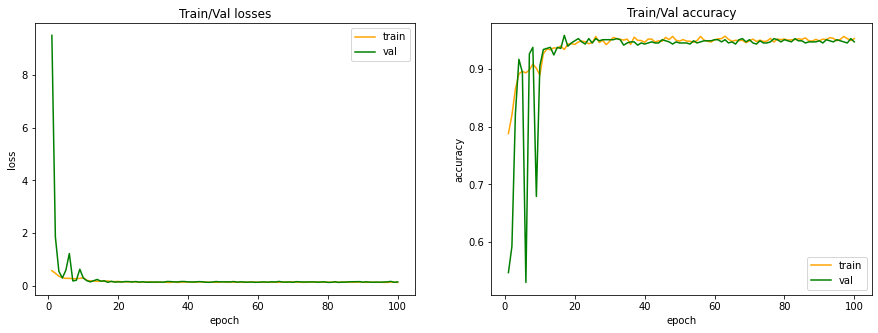

In [21]:
tensorbord(100,results_darknet53)

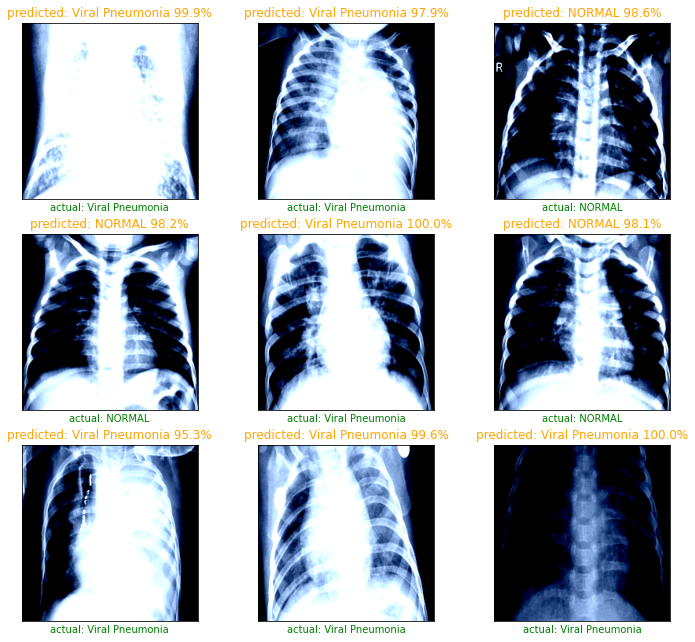

In [22]:
visualize_prediction(model=darknet53, num_images=9)

                 precision    recall  f1-score   support

       COVID-19       0.93      0.93      0.93        30
         NORMAL       0.93      1.00      0.97       250
Viral Pneumonia       0.99      0.92      0.95       250

       accuracy                           0.96       530
      macro avg       0.95      0.95      0.95       530
   weighted avg       0.96      0.96      0.96       530



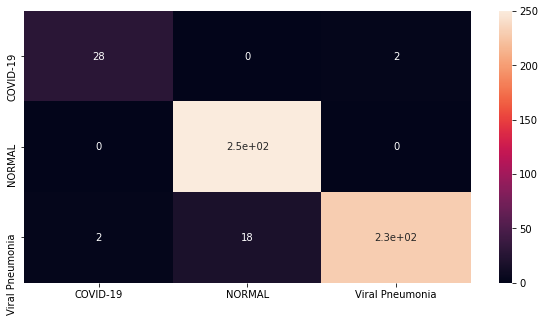

In [23]:
evaluate(darknet53)